In [3]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [12]:
import yfinance as yf
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Fetching real-time stock price data for Tesla
ticker = 'TSLA'
data = yf.download(ticker, start='2020-01-01', end=datetime.now().strftime('%Y-%m-%d'))

# Preprocessing the data
data['Date'] = data.index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Creating features
data['Day'] = data.index.day
data['Month'] = data.index.month
data['Year'] = data.index.year
data['DayOfWeek'] = data.index.dayofweek

# Shifting the Close price to create the target variable
data['Target'] = data['Close'].shift(-1)

# Dropping the last row as it contains NaN value for Target
data = data[:-1]

# Features and Target variable
X = data[['Open', 'High', 'Low', 'Close', 'Volume', 'Day', 'Month', 'Year', 'DayOfWeek']]
y = data['Target']



X

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume,Day,Month,Year,DayOfWeek
Date,,,,,,,,,
2020-01-02,28.299999,28.713333,28.114000,28.684000,142981500,2,1,2020,3
2020-01-03,29.366667,30.266666,29.128000,29.534000,266677500,3,1,2020,4
2020-01-06,29.364668,30.104000,29.333332,30.102667,151995000,6,1,2020,0
2020-01-07,30.760000,31.441999,30.224001,31.270666,268231500,7,1,2020,1
2020-01-08,31.580000,33.232666,31.215334,32.809334,467164500,8,1,2020,2
...,...,...,...,...,...,...,...,...,...
2024-06-11,173.919998,174.750000,167.410004,170.660004,64761900,11,6,2024,1
2024-06-12,171.119995,180.550003,169.800003,177.289993,90389400,12,6,2024,2
2024-06-13,188.389999,191.080002,181.229996,182.470001,118984100,13,6,2024,3


In [13]:
y

Date
2020-01-02     29.534000
2020-01-03     30.102667
2020-01-06     31.270666
2020-01-07     32.809334
2020-01-08     32.089333
                 ...    
2024-06-11    177.289993
2024-06-12    182.470001
2024-06-13    178.009995
2024-06-14    187.440002
2024-06-17    184.860001
Name: Target, Length: 1122, dtype: float64

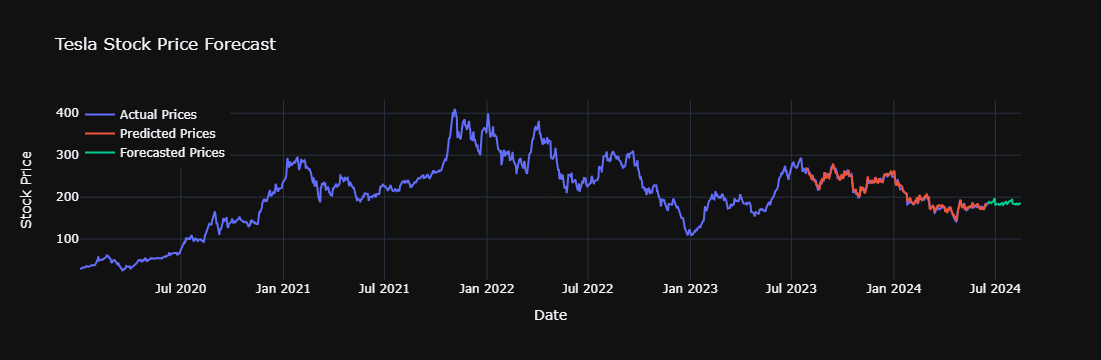

In [18]:

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Training the XGBoost Regressor
model = XGBRegressor(n_estimators=10000, learning_rate=0.08, random_state=42)
model.fit(X_train, y_train)

# Predicting the next 60 days
forecast_dates = [data.index[-1] + timedelta(days=i) for i in range(1, 61)]
forecast_df = pd.DataFrame(index=forecast_dates, columns=X.columns)

# Filling forecast_df with the same data from the last available date
for col in forecast_df.columns:
    forecast_df[col] = X.iloc[-1][col]

forecast_df['Day'] = forecast_df.index.day
forecast_df['Month'] = forecast_df.index.month
forecast_df['Year'] = forecast_df.index.year
forecast_df['DayOfWeek'] = forecast_df.index.dayofweek

# Making predictions
forecast = model.predict(forecast_df)

# Predicting on the test set
y_pred = model.predict(X_test)

# Creating the plot
fig = make_subplots()

# Adding actual prices
fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='Actual Prices'))

# Adding predicted prices
fig.add_trace(go.Scatter(x=X_test.index, y=y_pred, mode='lines', name='Predicted Prices'))#, line=dict(dash='dash')))

# Adding forecasted prices
fig.add_trace(go.Scatter(x=forecast_df.index, y=forecast, mode='lines', name='Forecasted Prices'))#, line=dict(dash='dot')))

# Updating layout
fig.update_layout(
    title='Tesla Stock Price Forecast',
    xaxis_title='Date',
    yaxis_title='Stock Price',
    legend=dict(x=0, y=1),
    template='plotly_dark'
)

# Display the plot
fig.show()

In [19]:
# Calculating and printing the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 7.582902152486438
